# Cancer Diagnosis Model




### Dataset: https://www.kaggle.com/c/msk-redefining-cancer-treatment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
import numpy as np
import nltk
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Download data

In [ ]:
!wget http://abcom.com/public-data/tutorials/ml-cancer-detection/training_text.zip

--2020-07-04 15:30:45--  http://abcom.com/public-data/tutorials/ml-cancer-detection/training_text.zip
Resolving abcom.com (abcom.com)... 172.67.220.7, 104.24.103.18, 104.24.102.18, ...
Connecting to abcom.com (abcom.com)|172.67.220.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   100%[===================>]  60.96M  34.0MB/s    in 1.8s    

2020-07-04 15:30:47 (34.0 MB/s) - ‘training_text.zip’ saved [63917183/63917183]



In [ ]:
!unzip training_text.zip

Archive:  training_text.zip
  inflating: training_text           


In [ ]:
!wget http://abcom.com/public-data/tutorials/ml-cancer-detection/training_variants.zip

--2020-07-04 15:31:04--  http://abcom.com/public-data/tutorials/ml-cancer-detection/training_variants.zip
Resolving abcom.com (abcom.com)... 172.67.220.7, 104.24.103.18, 104.24.102.18, ...
Connecting to abcom.com (abcom.com)|172.67.220.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24831 (24K) [application/zip]
Saving to: ‘training_variants.zip’

training_variants.z 100%[===================>]  24.25K  --.-KB/s    in 0.05s   

2020-07-04 15:31:04 (504 KB/s) - ‘training_variants.zip’ saved [24831/24831]



In [ ]:
!unzip training_variants.zip

Archive:  training_variants.zip
  inflating: training_variants       


# Examine data

In [ ]:
data = pd.read_csv('/content/training_variants')
data

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
...,...,...,...,...
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4


In [ ]:
data_text = pd.read_csv("/content/training_text", sep = "\|\|", engine = "python", names = ["ID","TEXT"], skiprows = 1)
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
data_text['TEXT'][1]

" Abstract Background  Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC.  Methods and Findings  Using archival formalin-fixed paraffin embedded (FFPE) extracted genomic DNA, we show that c-CBL mutations occur in somatic fashion for lung cancers. c-CBL mutations were not mutually exclusive of MET or EGFR mutations; however they were independent of p53 and KRAS mutations. In normal/tumor pairwise analysis, there was significant loss of heterozygosity (LOH) for the c-CBL locus (22%, n\u200a=\u200a8/37) and none of these samples revealed any mutation in the remaining copy of c-CBL. The c-CBL LOH also positively correlated with EGFR and MET mutations observed in the same samples. Using selec

In [ ]:
lu = data_text['TEXT'][1].split()
print(lu)

['Abstract', 'Background', 'Non-small', 'cell', 'lung', 'cancer', '(NSCLC)', 'is', 'a', 'heterogeneous', 'group', 'of', 'disorders', 'with', 'a', 'number', 'of', 'genetic', 'and', 'proteomic', 'alterations.', 'c-CBL', 'is', 'an', 'E3', 'ubiquitin', 'ligase', 'and', 'adaptor', 'molecule', 'important', 'in', 'normal', 'homeostasis', 'and', 'cancer.', 'We', 'determined', 'the', 'genetic', 'variations', 'of', 'c-CBL,', 'relationship', 'to', 'receptor', 'tyrosine', 'kinases', '(EGFR', 'and', 'MET),', 'and', 'functionality', 'in', 'NSCLC.', 'Methods', 'and', 'Findings', 'Using', 'archival', 'formalin-fixed', 'paraffin', 'embedded', '(FFPE)', 'extracted', 'genomic', 'DNA,', 'we', 'show', 'that', 'c-CBL', 'mutations', 'occur', 'in', 'somatic', 'fashion', 'for', 'lung', 'cancers.', 'c-CBL', 'mutations', 'were', 'not', 'mutually', 'exclusive', 'of', 'MET', 'or', 'EGFR', 'mutations;', 'however', 'they', 'were', 'independent', 'of', 'p53', 'and', 'KRAS', 'mutations.', 'In', 'normal/tumor', 'pairwi

In [ ]:
gene_vectorize = CountVectorizer()
train_gene_feature_onehotCodin = gene_vectorize.fit_transform(lu)
lop=gene_vectorize.vocabulary_
print(lop)

{'abstract': 109, 'background': 198, 'non': 855, 'small': 1143, 'cell': 260, 'lung': 759, 'cancer': 245, 'nsclc': 864, 'is': 693, 'heterogeneous': 611, 'group': 583, 'of': 875, 'disorders': 408, 'with': 1356, 'number': 866, 'genetic': 573, 'and': 169, 'proteomic': 1004, 'alterations': 154, 'cbl': 258, 'an': 163, 'e3': 435, 'ubiquitin': 1288, 'ligase': 739, 'adaptor': 127, 'molecule': 817, 'important': 648, 'in': 650, 'normal': 858, 'homeostasis': 619, 'we': 1337, 'determined': 393, 'the': 1231, 'variations': 1319, 'relationship': 1040, 'to': 1254, 'receptor': 1027, 'tyrosine': 1286, 'kinases': 709, 'egfr': 447, 'met': 795, 'functionality': 548, 'methods': 797, 'findings': 516, 'using': 1309, 'archival': 184, 'formalin': 534, 'fixed': 521, 'paraffin': 908, 'embedded': 452, 'ffpe': 510, 'extracted': 499, 'genomic': 574, 'dna': 413, 'show': 1122, 'that': 1230, 'mutations': 835, 'occur': 873, 'somatic': 1152, 'fashion': 505, 'for': 532, 'cancers': 246, 'were': 1340, 'not': 859, 'mutually':

In [ ]:
result = pd.merge(data, data_text, on ='ID', how = 'left')

In [ ]:
lst = []
for k in lop.keys():  
  if(k=="cbl" or k=="w802*" or k=="q249e" or k=="n454d"):
       lst.append(k)
print(lst)

['cbl', 'q249e']


# Pre-processing text



In [ ]:
import string
regex1 = re.compile('[%s]' % re.escape(string.digits))
regex2 = re.compile('[%s]' % re.escape(string.punctuation))
def remove(sentence):
  reg = regex1.sub('',sentence)
  reg = regex2.sub('',reg)
  return reg

In [ ]:
data_text['TEXT'] = data_text['TEXT'].apply(lambda x: remove(str(x)))

In [ ]:
#replacing every null value  with gene value and variations.
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation'] 

In [ ]:
y_true = result['Class'].values 
X_train, X_test, Y_train, Y_test = train_test_split(result, 
                                                    y_true, 
                                                    stratify = y_true, 
                                                    test_size = 0.2)
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_train, Y_train, 
                       stratify = Y_train, test_size = 0.2)



#Plotting confusion matrix.

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(C, annot = True, cmap = "YlGnBu", fmt = ".3f", 
                xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Creating random model for benchmarking

In [ ]:
# Test dataset
test_data_len = X_test.shape[0]
# Number of rows equals number of test datapoints
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    # generate 9 random  numbers for our random classes.
    rand_probs = np.random.rand(1,9)
    # divide each with the sum of all
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",
      log_loss(Y_test, test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.50695329882052


-------------------- Confusion matrix --------------------


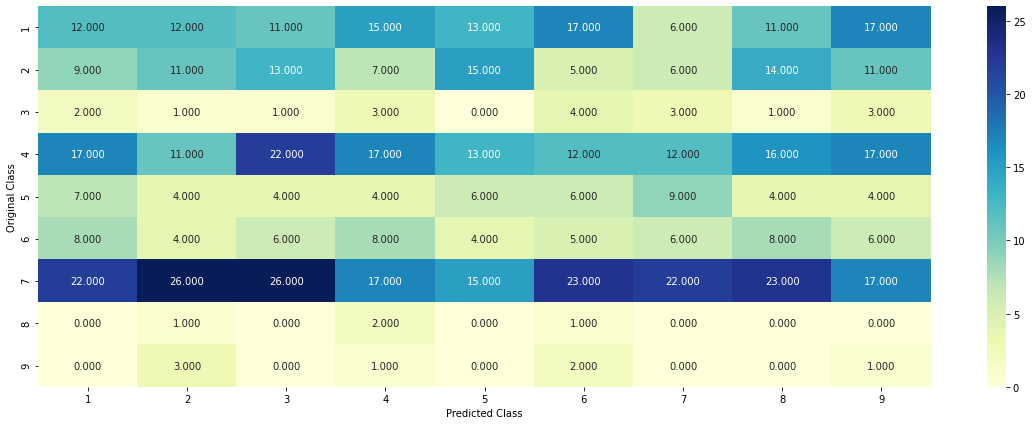

In [ ]:
# get the max probability
predicted_y = np.argmax(test_predicted_y, axis = 1) 
plot_confusion_matrix(Y_test, predicted_y+1) 

In [ ]:
cv_data_len = X_test_cv.shape[0]

# Cross validation dataset
cv_predicted_y = np.zeros((cv_data_len,9)) 
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9) 
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) 

print("Log loss on Cross Validation Data using Random Model",
      log_loss(Y_test_cv, cv_predicted_y, eps = 1e-15))

Log loss on Cross Validation Data using Random Model 2.501899686140036


In [ ]:
# one-hot encoding of gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_train_cv['Gene'])

# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_train_cv['Variation'])

# one-hot encoding of text feature.
# Minimum frequency for words = 3 and remove all stop words
text_vectorizer = CountVectorizer(min_df = 3, stop_words = 'english')
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis = 0)
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis = 0)
cv_text_feature_onehotCoding = text_vectorizer.transform(X_train_cv['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis = 0)

In [ ]:
# merging gene, variation and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,
                                      train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,
                                     test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,
                                   cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, 
                               train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, 
                              test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, 
                            cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_train_cv['Class']))

# Logistic Regression with class balancing.

### Selecting best alpha value

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', 
                        alpha = i, penalty = 'l2', 
                        loss = 'log', random_state = 42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, 
                                       labels = clf.classes_, eps = 1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 0.8003154260993842
for alpha = 1e-05
Log Loss : 0.7079369368172093
for alpha = 0.0001
Log Loss : 0.4236510603153114
for alpha = 0.001
Log Loss : 0.47905817434024117
for alpha = 0.01
Log Loss : 0.7023689913108854
for alpha = 0.1
Log Loss : 1.3087910051247271
for alpha = 1
Log Loss : 1.582664690845713
for alpha = 10
Log Loss : 1.6160706485774115
for alpha = 100
Log Loss : 1.6196237377984173


### Train with the best alpha

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = 'balanced', 
                    alpha = alpha[best_alpha], penalty = 'l2', 
                    loss='log', random_state = 42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                    

In [ ]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("The train log loss is:",
      log_loss(Y_train, predict_y, labels = clf.classes_, eps = 1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",
      log_loss(Y_train_cv, predict_y, labels = clf.classes_, eps = 1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("The test log loss is:",
      log_loss(Y_test, predict_y, labels = clf.classes_, eps = 1e-15))

The train log loss is: 0.44942516536921395
The cross validation log loss is: 0.4236510603153114
The test log loss is: 1.1059863674720052


# Model evaluation

In [ ]:
def predict_and_plot_confusion_matrix(train_x, train_y,
                                      test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # Display number of data points that are misclassified
    print("Number of mis-classified points :", 
          np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

Number of mis-classified points : 0.03766478342749529
-------------------- Confusion matrix --------------------


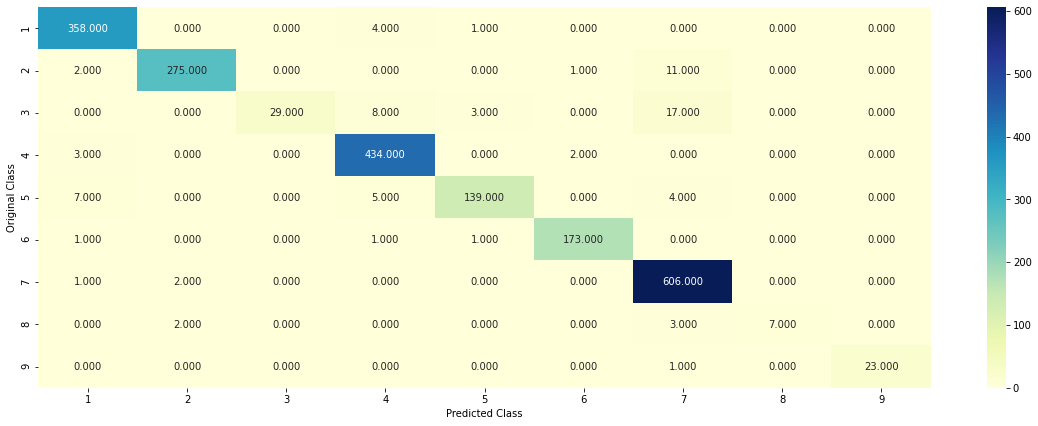

In [ ]:
clf = SGDClassifier(class_weight = 'balanced', 
                    alpha = alpha[best_alpha], penalty = 'l2', 
                    loss = 'log', random_state = 42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, 
                                  train_y, cv_x_onehotCoding, 
                                  cv_y, clf)

# Feature importance for interpretability of our model.


In [ ]:
 def getImportantFeatures(indices, gene, variation, text, noOfFeatures):
 
    gene_features = gene_vectorizer.get_feature_names()
    variation_features = variation_vectorizer.get_feature_names()
    text_features = text_vectorizer.get_feature_names()
    
    gene_feat_len = len(gene_features)
    var_feat_len = len(variation_features)
    text_features_len =len(text_features)
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < gene_feat_len:
            word = gene_features[v]
            if word == gene:
                word_present += 1
                print("{}st Gene feature [{}] is present in query point [{}]".format(i+1, word,bool_var))
                    
        elif (v < gene_feat_len + var_feat_len):
            word = variation_features[v - gene_feat_len]           
            if word == variation:
                word_present += 1
                print("{}th Variation feature [{}] is present in query point".format(i+1, word))
        else:
            word = text_features[v - (gene_feat_len + var_feat_len)]

            if word in text.split():              
                word_present += 1
                print("{}th Text feature [{}] is present in query point".format(i+1, word))
                    
    print("-"*63)                
    print("Out of the top "+str(noOfFeatures)+" features "+
          str(word_present)+" are present in query point")
    print("-"*63)   

In [ ]:
testDataPoint = 500
top_features = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[testDataPoint])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[testDataPoint]),4))
print("Actual Class :", test_y[testDataPoint])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:top_features]
getImportantFeatures(indices[0], X_test.iloc[testDataPoint]["Gene"], 
                     X_test.iloc[testDataPoint]["Variation"], 
                     X_test.iloc[testDataPoint]["TEXT"], top_features)

Predicted Class : 7
Predicted Class Probabilities: [[0.0419 0.3518 0.0116 0.0197 0.0158 0.015  0.5318 0.0061 0.0063]]
Actual Class : 2
546th Text feature [constitutive] is present in query point
---------------------------------------------------------------
Out of the top 1000 features 1 are present in query point
---------------------------------------------------------------


#References

#https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

## https://stackoverflow.com/a/18662466/4084039

#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

#http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

#https://medium.com/@tulasiram11729/personalized-cancer-diagnosis-3d6f09a6b8c9